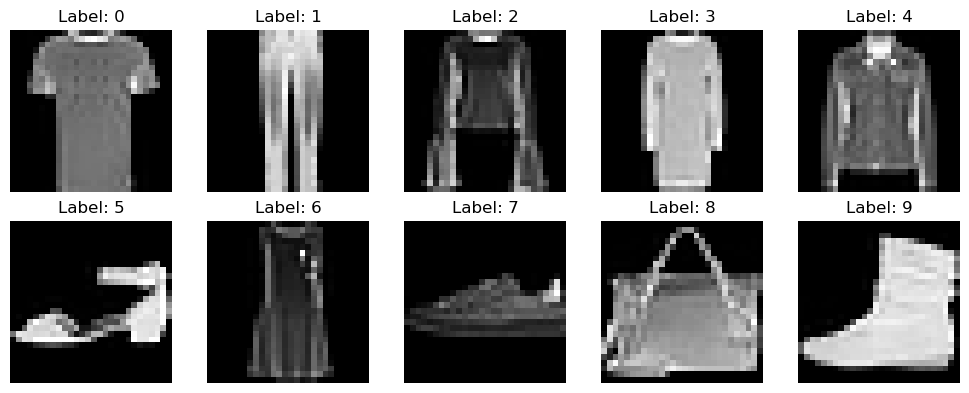

       label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0          6       0       0       0       0       0       0       0       0   
1          8       0       0       0       0       0       0       0       0   
2          9       0       0       0       0       0       0       0       0   
3          0       0       0       0       1       0       0       0       0   
4          0       0       0       0       0       0       1       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
47995      2       0       0       0       0       0       0       0       0   
47996      9       0       0       0       0       0       0       0       0   
47997      7       0       0       0       0       0       0       0       0   
47998      0       0       0       0       0       0       0      17      99   
47999      3       0       0       0       0       0       0       0       0   

       pixel9  ...  pixel775  pixel776 

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder


# Load the fixed CSV
df = pd.read_csv("fashion-mnist_train.csv")

# Group by class label
grouped = df.groupby("label")

# Prepare empty lists for train and test splits
train_list = []
test_list = []

# Split each class group into 80% train and 20% test
for label, group in grouped:
    train_split, test_split = train_test_split(
        group, 
        test_size=0.2, 
        random_state=42, 
        shuffle=True,
        stratify=None  # We are already splitting by class manually
    )
    train_list.append(train_split)
    test_list.append(test_split)

# Concatenate all class-wise splits
train_df = pd.concat(train_list).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat(test_list).sample(frac=1, random_state=42).reset_index(drop=True)


# One example per class
examples = train_df.groupby("label").first().reset_index()

# Plot
plt.figure(figsize=(10, 4))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    img = examples.loc[i].drop("label").values.astype(np.uint8).reshape(28, 28)
    plt.imshow(img, cmap="gray")
    plt.title(f"Label: {examples.loc[i, 'label']}")
    plt.axis("off")

plt.tight_layout()
plt.show()
print(train_df)
print(test_df)


In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

np.random.seed(42)

def ReLU(x):
    return np.maximum(0, x)

def ReLU_D(x):
    return np.where(x > 0, 1, 0)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_D(a):
    return a * (1 - a)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Normalize and encode labels
X_train = train_df.drop("label", axis=1).values / 255.0
y_train = train_df["label"].values.reshape(-1, 1)
X_test = test_df.drop("label", axis=1).values / 255.0
y_test = test_df["label"].values.reshape(-1, 1)

encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)
np.random.seed(0)
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

layers = [X_train.shape[1], 512, 256, 128, 10]
activation = ['ReLU', 'ReLU', 'ReLU', 'softmax']

def init_weights(layers):
    weights = {}
    biases = {}
    for i in range(1, len(layers)):
        if activation[i - 1] == "ReLU":
            weights[f"W{i}"] = np.random.randn(layers[i - 1], layers[i]) * np.sqrt(2 / layers[i - 1])
        elif activation[i - 1] == "sigmoid":
            weights[f"W{i}"] = np.random.randn(layers[i - 1], layers[i]) * np.sqrt(1 / layers[i - 1])
        else:
            weights[f"W{i}"] = np.random.randn(layers[i - 1], layers[i]) * 0.01
        biases[f"b{i}"] = np.zeros((1, layers[i]))
    return weights, biases

def forward_pass(X, weights, biases, activation):
    cache = {"A0": X}
    A = X
    for i in range(1, len(activation) + 1):
        Z = np.dot(A, weights[f"W{i}"]) + biases[f"b{i}"]
        if activation[i - 1] == "ReLU":
            A = ReLU(Z)
        elif activation[i - 1] == "sigmoid":
            A = sigmoid(Z)
        elif activation[i - 1] == "softmax":
            A = softmax(Z)
        cache[f"Z{i}"] = Z
        cache[f"A{i}"] = A
    return A, cache

def backward_pass(y_true, weights, cache, activation):
    grads = {}
    m = y_true.shape[0]
    L = len(activation)
    dZ = cache[f"A{L}"] - y_true

    for i in reversed(range(1, L + 1)):
        A_prev = cache[f"A{i - 1}"]
        grads[f"dW{i}"] = np.dot(A_prev.T, dZ) / m
        grads[f"db{i}"] = np.sum(dZ, axis=0, keepdims=True) / m
        if i > 1:
            dA_prev = np.dot(dZ, weights[f"W{i}"].T)
            if activation[i - 2] == "ReLU":
                dZ = dA_prev * ReLU_D(cache[f"Z{i - 1}"])
            elif activation[i - 2] == "sigmoid":
                dZ = dA_prev * sigmoid_D(cache[f"A{i - 1}"])
    return grads

def update_weights(weights, biases, grads, lr):
    for key in weights:
        weights[key] -= lr * grads[f"d{key}"]
    for key in biases:
        biases[key] -= lr * grads[f"d{key}"]
    return weights, biases

def accuracy(X, y, weights, biases, activation):
    y_pred, _ = forward_pass(X, weights, biases, activation)
    predictions = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(y, axis=1)
    return np.mean(predictions == true_labels)

def train(X, y, layers, activation, epochs=600, lr=0.01, lemda=0.01, batch_size=64):
    weights, biases = init_weights(layers)
    loss_history = []
    m = X.shape[0]
    best_test_acc = 0
    best_weights = None
    best_biases = None

    for epoch in range(epochs):
        pack = np.random.permutation(m)
        X_shuffled = X[pack]
        y_shuffled = y[pack]

        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            b_size = X_batch.shape[0]

            y_pred, cache = forward_pass(X_batch, weights, biases, activation)
            L_loss = -np.sum(y_batch * np.log(y_pred + 1e-9)) / b_size
            reg = (lemda / (2 * b_size)) * sum(np.sum(weights[f"W{k}"] ** 2) for k in range(1, len(layers)))
            loss = L_loss + reg

            grads = backward_pass(y_batch, weights, cache, activation)
            for k in range(1, len(layers)):
                grads[f"dW{k}"] += (lemda / b_size) * weights[f"W{k}"]

            weights, biases = update_weights(weights, biases, grads, lr)

        loss_history.append(loss)

        if epoch % 10 == 0 or epoch == epochs - 1:
            train_acc = accuracy(X, y, weights, biases, activation)
            test_acc = accuracy(X_test, y_test_encoded, weights, biases, activation)
            print(f"Epoch {epoch}: Loss = {loss:.4f}, Train Acc = {train_acc*100:.2f}%, Test Acc = {test_acc*100:.2f}%")

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_weights = {k: v.copy() for k, v in weights.items()}
            best_biases = {k: v.copy() for k, v in biases.items()}

    return weights, biases, loss_history, best_weights, best_biases

weights_trained, biases_trained, loss_history, best_weights, best_biases = train(X_train, y_train_encoded, layers, activation)

print("Final Train Accuracy:", round(accuracy(X_train, y_train_encoded, weights_trained, biases_trained, activation) * 100, 2), "%")
print("Final Test Accuracy:", round(accuracy(X_test, y_test_encoded, weights_trained, biases_trained, activation) * 100, 2), "%")

plt.plot(loss_history)


Epoch 0: Loss = 0.7225, Train Acc = 81.77%, Test Acc = 81.37%
Epoch 10: Loss = 0.4261, Train Acc = 90.08%, Test Acc = 87.68%


In [5]:
print("Best weights for layer 1:\n", weights_trained["W1"])
print("Best biases for layer 1:\n", biases_trained["b1"])


Best weights for layer 1:
 [[ 4.35516867e-02  1.23442994e-02  2.43089594e-02 ...  3.38322872e-02
   2.27121686e-02  3.55775990e-02]
 [-3.39139218e-02 -4.69317654e-02 -1.67159633e-02 ...  1.88981828e-02
  -1.01953675e-02 -2.60483098e-02]
 [ 4.16820269e-02 -1.73046231e-02 -2.56787870e-02 ...  8.89972493e-03
  -7.44257648e-03 -2.79630056e-02]
 ...
 [-2.92263096e-02 -1.74009135e-02  3.43159928e-02 ...  2.39631499e-02
   2.99877064e-02  2.62419367e-02]
 [-4.36491467e-02  2.23396659e-02  4.23997034e-02 ...  5.84975446e-05
   4.01859765e-02  2.32309065e-02]
 [-1.99004216e-02  2.93596958e-02 -1.64445859e-02 ...  1.32162371e-03
   1.99570570e-02  1.56842328e-03]]
Best biases for layer 1:
 [[ 1.66038566e-03 -4.56495016e-03  1.71183823e-04 -1.19515751e-03
  -5.08336376e-03 -4.18935228e-03 -2.28058080e-03  1.22429754e-03
   3.19365505e-03 -1.08059874e-02 -5.62389083e-04  1.48514839e-02
  -6.99221755e-03  1.00591150e-03 -1.07145189e-03  2.76628260e-03
   6.64385557e-03  2.31560785e-02  7.54857797e-

In [7]:

test_df = pd.read_csv("fashion-mnist_test.csv")
X_test = test_df.drop("label", axis=1).values / 255.0
y_test = test_df["label"].values.reshape(-1, 1)

X_test = (X_test - mean) / std

y_test_encoded = encoder.transform(y_test)

f_output, _ = forward_pass(X_test, weights_trained, biases_trained, activation)

f_acc = accuracy(X_test, y_test_encoded, weights_trained, biases_trained, activation)
print(f"Final Accuracy : {f_acc * 100:.2f}%")
print("Final Cost :", loss_history[-1])


Final Accuracy : 90.08%
Final Cost : 0.057287378596393365


In [ ]:
# with augmentation
from PIL import Image, ImageOps
import random

df = pd.read_csv("fashion-mnist_test.csv")
labels = df['label'].values
images = df.drop('label', axis=1).values.reshape(-1, 28, 28).astype(np.uint8)

def augment_image(img_array):
    img = Image.fromarray(img_array)

    if random.random() > 0.5:
        img = ImageOps.mirror(img)  
    if random.random() > 0.5:
        img = img.rotate(random.choice([-15, -10, -5, 5, 10, 15]))  
    
    return np.array(img)


batch_size = 64 
idxs = np.random.choice(len(images), batch_size, replace=False)
batch_imgs = images[idxs]
batch_labels = labels[idxs]


augmented_batch = np.array([augment_image(img) for img in batch_imgs])


plt.figure(figsize=(10, 5))
for i in range(batch_size):
    plt.subplot(2, 4, i+1)  
    plt.imshow(augmented_batch[i], cmap='gray')
    plt.title(f"Label: {batch_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
